In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.externals import joblib
import datetime
import h5py
import pickle
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from keras_contrib.layers import crf

Using TensorFlow backend.


# Work with audioset data

In [2]:
def load_data(hdf5_path):
    with h5py.File(hdf5_path, 'r') as hf:
        x = hf.get('x')
        y = hf.get('y')
        video_id_list = hf.get('video_id_list')
        x = np.array(x)
        y = list(y)
        video_id_list = list(video_id_list)
        
    return x, y, video_id_list

def uint8_to_float32(x):
    return (np.float32(x) - 128.) / 128.
    
def bool_to_float32(y):
    return np.float32(y)

In [3]:
# load data an transform in right space

(x, y, video_id_list) = load_data('./AudioSet/packed_features/bal_train.h5')
x = uint8_to_float32(x)# shape: (N, 10, 128)
y = bool_to_float32(y)# shape: (N, 527)

In [4]:
x.shape

(22160, 10, 128)

In [5]:
# import labels (with 2 manually divided flags)

labels = pd.read_csv("./AudioSet/class_labels_indices.csv")
labels

In [7]:
# find speech and sing labels

speech_labels = labels[labels["is_speaking"] == 1]["index"].values
music_labels = labels[labels["is_singing"] == 1]["index"].values

In [13]:
# collect all speech and music idxs

music_idxs = []
speech_idxs = []

for i,val in tqdm(enumerate(y)):
    nnz_idxs = val.nonzero()[0]
    if any([idx in music_labels for idx in nnz_idxs]): 
        music_idxs.append(i)
    if any([idx in speech_labels for idx in nnz_idxs]): 
        speech_idxs.append(i)

22160it [00:00, 30476.99it/s]


In [15]:
music_set = set(music_idxs)
speech_set = set(speech_idxs)
music_set_clear = music_set.difference(speech_set)
speech_set_clear = speech_set.difference(music_set)

In [16]:
len(music_set_clear)

6000

In [17]:
len(speech_set_clear)

4719

In [18]:
set(music_set_clear).intersection(speech_set_clear)

set()

In [19]:
# collect arrays for speech and singing

music_data = np.zeros((len(music_set_clear),10,128),dtype=np.float32)
speech_data = np.zeros((len(speech_set_clear),10,128), dtype=np.float32)

for i,idx in enumerate(music_set_clear):
    music_data[i,:,:] = x[idx,:,:]
    
for i, idx in enumerate(speech_set_clear):
    speech_data[i,:,:] = x[idx,:,:]

In [20]:
def generate_data_sample(music_data,speech_data, N_music_min, 
                         N_music_max, N_speech_min, N_speech_max,
                         N_samples=10000, seq_len=100, embed_dim=128):
    
    number_tracks = int(round(seq_len)/10)
    data_sample = np.zeros((N_samples,seq_len,embed_dim),dtype=np.float32)
    mask_sample = np.zeros((N_samples,seq_len,1),dtype=np.float32)
    for i in tqdm(range(N_samples)):
        # generat audio features
        
        for k in range(number_tracks):
            rand_idx = np.random.randint(N_speech_min, N_speech_max)
            data_sample[i,10*k:10*(k+1),:] = speech_data[rand_idx,:,:]
    
        # randomly select position for music part
    
        start = np.random.randint(int(-0.2*seq_len),int(1.2*seq_len))
        duration = np.random.randint(seq_len)
        finish = start + duration
        if start < 0:
            start = 0
        if finish < 0:
            continue
        if start < seq_len:
            if finish > seq_len:
                finish = seq_len
            mask_sample[i,start:finish,0] = 1.0
            curr_music_len = finish - start
            while curr_music_len > 10:
                rand_idx = np.random.randint(N_music_min, N_music_max)
                data_sample[i,start:start+10,:] = music_data[rand_idx,:,:]
                start += 10
                curr_music_len = finish - start
            rand_idx = np.random.randint(N_music_min,N_music_max)
            data_sample[i,start:finish,:] = music_data[rand_idx,:curr_music_len,:]
    return data_sample, mask_sample

In [21]:
# generate train, val and test data

N_music = len(music_set_clear)
N_speech = len(speech_set_clear)

# train
tr_data, y_tr = generate_data_sample(music_data,speech_data,N_music_min=0,N_music_max=int(N_music*0.64),
                                     N_speech_min=0, N_speech_max=int(0.64*N_speech), N_samples=50000)

val_data,y_val = generate_data_sample(music_data,speech_data,N_music_min=int(N_music*0.64),N_music_max=int(N_music*0.8),
                                     N_speech_min=int(0.64*N_speech), N_speech_max=int(0.8*N_speech), N_samples=5000)

te_data, y_te = generate_data_sample(music_data,speech_data,N_music_min=int(N_music*0.8),N_music_max=N_music,
                                     N_speech_min=int(0.8*N_speech), N_speech_max=N_speech, N_samples=5000)

100%|██████████| 5000/5000 [00:00<00:00, 6437.48it/s]


# Build keras model 

In [23]:
import keras
from keras.layers import Activation, TimeDistributed, Dense, RepeatVector, recurrent,Conv1D,SpatialDropout1D,Reshape
from keras.layers.wrappers import Bidirectional
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Lambda, Activation
from keras.optimizers import RMSprop, Adam
from keras.layers.normalization import BatchNormalization
from keras.layers.wrappers import Bidirectional
from keras import backend as K
from keras.layers import Input,GRU, Layer
from keras.layers.merge import add, concatenate, dot
from keras.models import Model
from keras.layers.pooling import AveragePooling1D,GlobalAveragePooling1D
from keras.layers import GaussianDropout

Using TensorFlow backend.


In [25]:
# define simple RNN model

seq_len = 100
embed_dim = 128

model = Sequential()
model.add(Layer(input_shape=(None,embed_dim,)))
#model.add(GaussianDropout(0.05))
#model.add(TimeDistributed(Dense(16, activation = 'relu')))
model.add(Bidirectional(GRU(128,recurrent_dropout=0.2,return_sequences=True)))
model.add(Dropout(0.2))
#model.add(GaussianDropout(0.05))
#model.add(Bidirectional(GRU(64,recurrent_dropout=0.2,return_sequences=True)))
#model.add(GaussianDropout(0.05))
#model.add(Dropout(0.2))
#model.add(TimeDistributed(Dense(16, activation = 'relu')))
model.add(TimeDistributed(Dense(1, activation = 'sigmoid')))


model.compile(loss='binary_crossentropy',
             optimizer='adam',
            metrics=['accuracy'])

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Layer)              (None, None, 128)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 256)         197376    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 1)           257       
Total params: 197,633
Trainable params: 197,633
Non-trainable params: 0
_________________________________________________________________


In [1079]:
# define slow schedule

from keras.callbacks import ModelCheckpoint, LearningRateScheduler,EarlyStopping
lr_scheduler_callback = LearningRateScheduler(lambda epoch:
                                                      0.001 if epoch < 3
                                                      else 0.0003)

In [948]:
# define fast schedule

lr_scheduler_callback = LearningRateScheduler(lambda epoch:
                                                      0.003 if epoch < 3
                                                      else 0.001)

In [1106]:
# train model

filepath = './model_cpt/model_LG_None_gru_128_new_split_do_fast_sch.h5'
my_callback = keras.callbacks.ModelCheckpoint(filepath, monitor = 'val_loss', verbose = 0, save_best_only = True, save_weights_only=False, mode='auto')
model.fit(tr_data, y_tr,batch_size=32,
          validation_data = (val_data,y_val),
          epochs=30,
          callbacks = [my_callback, lr_scheduler_callback,EarlyStopping(monitor='val_loss', patience = 3, verbose = 0)])

Train on 50000 samples, validate on 5000 samples
Epoch 1/30
50000/50000 [==============================] - 72s 1ms/step - loss: 0.1366 - acc: 0.9524 - val_loss: 0.1743 - val_acc: 0.9454

# Work with different models

In [29]:
model = load_model('./model_cpt/model_LG_None_gru_128_new_split_do_fast_sch.h5')

In [835]:
model = load_model("./model_cpt/model_LG_None_gru_gru_64_new_split_do.h5")

In [695]:
model = load_model("./model_cpt/model_LG_None_gru_gru_64_new_split_gdo.h5")

In [855]:
model = load_model("./model_cpt/model_LG_None_gru_64_new_split_gdo.h5")

In [732]:
model = load_model("./model_cpt/model_LG_None_gru_64_new_split_do.h5")

In [750]:
model = load_model("./model_cpt/model_LG_None_gru_64_new_split_dense_16.h5")

In [769]:
model = load_model("./model_cpt/model_LG_None_gru_64_new_split.h5")

In [787]:
model = load_model("./model_cpt/model_LG_None_gru_128.h5")

In [28]:
from keras.models import load_model
model = load_model("./model_cpt/model_LG.h5")

In [169]:
y_te_pred = model.predict(te_data)

In [170]:
y_te_pred[1,:,0]

array([2.5260425e-04, 1.0684109e-04, 2.8565651e-04, 2.6226082e-04,
       4.1874856e-04, 2.9217845e-04, 4.7163479e-03, 1.2081396e-01,
       9.8518777e-01, 9.9993622e-01, 9.9999881e-01, 9.9999964e-01,
       9.9999976e-01, 9.9999559e-01, 9.9999809e-01, 9.9999869e-01,
       9.9999881e-01, 9.9999964e-01, 9.9999893e-01, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 9.9999988e-01, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       9.9999881e-01, 1.0000000e+00, 9.9999988e-01, 9.9999988e-01,
       9.9999988e-01, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       9.9999976e-01, 9.9999833e-01, 9.9999952e-01, 9.9997330e-01,
       9.9999881e-01, 9.9999988e-01, 9.9999976e-01, 9.9999988e-01,
       9.9999940e-01, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       9.9999607e-01, 9.9997139e-01, 9.9501640e-01, 6.2961060e-01,
       8.6017884e-03, 1.3790854e-03, 3.7628852e-04, 2.2914157e-04,
       3.5863384e-05, 3.4979644e-06, 1.3156672e-06, 1.2890650e

In [171]:
np.argmax(y_te[7,:,0])

82

In [172]:
y_te[7,:,0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [173]:
q = y_te_pred[7,:,0]
q = [int(t > 0.5) for t in q]

In [174]:
np.argmax(q)

82

# Download real sample from youtube

In [3]:
import pytube

In [5]:
# download audio stream from youtube video

from pytube import YouTube
yt = YouTube("https://www.youtube.com/watch?v=u_tgwZfolQk")
yt.streams.filter(only_audio=True).first().download('./awg')

'./awg/Alissa White-Gluz - Canadian idol.mp4'

In [9]:
# download audio stream from youtube video

from pytube import YouTube
yt = YouTube("https://www.youtube.com/watch?v=m2vtzcVU8eU")
yt.streams.filter(only_audio=True).first().download('./voice_nl/')

'./voice_nl/The Voice Of Ireland Season 4 Episode 1 Blind Auditions 1.mp4'

In [ ]:
# download audio stream from youtube video

from pytube import YouTube
yt = YouTube("https://www.youtube.com/watch?v=mpUTF5X5oTQ")
yt.streams.filter(only_audio=True).first().download('./epica')

In [ ]:
# download audio stream from youtube video

from pytube import YouTube
yt = YouTube("https://www.youtube.com/watch?v=tYKaGH2yyik")
yt.streams.filter(only_audio=True).first().download('./real_sample')

In [8]:
# download audio stream from youtube video (Lacuna Coil)

from pytube import YouTube
yt = YouTube("https://www.youtube.com/watch?v=G24d6Hx7uKg")
yt.streams.filter(only_audio=True).first().download('./lacuna_coil')

'./lacuna_coil/Lacuna Coil (live) Full Acoustic Set from the Dark Legacy Tour 2012.mp4'

# Work with real data

In [1208]:
data_dict.keys()

dict_keys(['embedings_list', 'files_list'])

In [32]:
with open("voice_sample.pkl","rb") as handle:
    data_dict_new = pickle.load(handle)

In [1273]:
with open("lacuna_coil_sample.pkl","rb") as handle:
    data_dict_new = pickle.load(handle)

In [33]:
real_sample = data_dict_new["embedings_list"]

In [1276]:
real_sample = data_dict["embedings_list"]

In [1277]:
real_sample[0].shape

(833, 128)

In [35]:
real_sample = real_sample[0]
real_sample = real_sample.reshape((1,real_sample.shape[0],real_sample.shape[1]))

In [36]:
real_sample.shape

(1, 833, 128)

In [37]:
real_sample = uint8_to_float32(real_sample)

In [38]:
real_lns = real_sample.shape[1]
tracks = int(real_lns/seq_len)
real_mask = np.zeros((real_lns,1),dtype=np.float32)
for i in range(tracks):
    q = model.predict(real_sample[:,i*seq_len:(i+1)*seq_len,:])
    q = q[0,:,0]
    real_mask[i*seq_len:(i+1)*seq_len,0]=q
q = model.predict(real_sample[:,tracks*seq_len:,:])
q = q[0,:,0]
real_mask[tracks*seq_len:,0]= q

In [39]:
real_mask = real_mask.reshape(-1)

# Post-process results

In [40]:
# use gaussian convolution for smoothing mask

from astropy.convolution import Gaussian1DKernel, convolve

# Create kernel
g = Gaussian1DKernel(stddev=5)

# Convolve data
smooth_mask = convolve(real_mask, g, boundary='extend')

In [41]:
smooth_mask[48:90]

array([0.19697392, 0.22123341, 0.24575095, 0.2696187 , 0.29190996,
       0.31170774, 0.32815292, 0.3405103 , 0.34825942, 0.3511397 ,
       0.3492097 , 0.34282464, 0.33258224, 0.31923145, 0.3035553 ,
       0.28627425, 0.26798016, 0.24910209, 0.22992963, 0.21067512,
       0.19153236, 0.17274575, 0.15463479, 0.13759413, 0.12204324,
       0.1083791 , 0.09688202, 0.08768185, 0.08074903, 0.07587294,
       0.07276428, 0.07110921, 0.07064834, 0.07126822, 0.07303784,
       0.07623231, 0.08130047, 0.08877831, 0.09916599, 0.11275329,
       0.1294827 , 0.14880507], dtype=float32)

In [45]:
q[44:]

array([], dtype=float32)

In [46]:
q = [int(t > 0.2) for t in smooth_mask]

In [47]:
q

[0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [48]:
idxs = np.nonzero(q)[0]

In [49]:
idxs

array([  5,   6,   7,   8,   9,  10,  11,  12,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  92,  93,  94,  95,  96,  97,  98,  99, 105, 106, 107, 108,
       109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       176, 177, 178, 179, 180, 181, 188, 189, 190, 191, 192, 193, 194,
       195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207,
       208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,
       221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
       234, 235, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278,
       279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291,
       292, 293, 294, 295, 296, 297, 298, 306, 307, 308, 309, 310, 311,
       312, 313, 314, 315, 325, 326, 327, 328, 329, 330, 331, 332, 333,
       334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 34

In [50]:
def aggregate_intervals(idxs,max_lag=4):
    
    fragments_list = []
    start_segment = idxs[0]
    finish_segment = idxs[0]
    prev_val = idxs[0]
    for v in idxs:
        if v - prev_val < max_lag:
            prev_val = v
            finish_segment = v
        else:
            if finish_segment - start_segment > 10:
                fragments_list.append([start_segment,finish_segment])
                start_segment = v
                finish_segment = v
                prev_val = v
            else:
                start_segment = v
                finish_segment = v
                prev_val = v
    if finish_segment - start_segment > 10:
        fragments_list.append([start_segment,finish_segment])
    return fragments_list

def sec_2_time(s):
    return str(datetime.timedelta(seconds=s))

def transform_to_time(res):
    intervals = [[sec_2_time(int(0.96*q)) for q in v] for v in res]
    return intervals

In [51]:
res = aggregate_intervals(idxs)
res = transform_to_time(res)

In [52]:
res

[['0:00:23', '0:00:34'],
 ['0:00:47', '0:01:04'],
 ['0:01:40', '0:01:56'],
 ['0:03:00', '0:03:45'],
 ['0:04:17', '0:04:46'],
 ['0:05:12', '0:05:52'],
 ['0:06:25', '0:07:02'],
 ['0:07:45', '0:08:25'],
 ['0:10:33', '0:13:18']]

In [53]:
smooth_mask

array([0.10944484, 0.12499754, 0.1432895 , 0.16354518, 0.18453616,
       0.20467237, 0.22217701, 0.23531744, 0.2426677 , 0.24334833,
       0.23716831, 0.22467747, 0.20709752, 0.18616146, 0.16390762,
       0.14244744, 0.12378556, 0.10966601, 0.10148458, 0.10023598,
       0.10647757, 0.12029738, 0.14127216, 0.16842462, 0.20021558,
       0.23457386, 0.2689974 , 0.30075192, 0.32712567, 0.3457524 ,
       0.35487658, 0.35362476, 0.34211555, 0.32148424, 0.2937216 ,
       0.26139495, 0.22734979, 0.19436385, 0.16484864, 0.14066252,
       0.12300341, 0.11242185, 0.10890715, 0.1120114 , 0.12099449,
       0.13495065, 0.15291168, 0.1738987 , 0.19697392, 0.22123341,
       0.24575095, 0.2696187 , 0.29190996, 0.31170774, 0.32815292,
       0.3405103 , 0.34825942, 0.3511397 , 0.3492097 , 0.34282464,
       0.33258224, 0.31923145, 0.3035553 , 0.28627425, 0.26798016,
       0.24910209, 0.22992963, 0.21067512, 0.19153236, 0.17274575,
       0.15463479, 0.13759413, 0.12204324, 0.1083791 , 0.09688

# Hardcoded labeling

In [1298]:
# lacuna coil

ratio = 100/96
true_value = np.zeros(len(q),dtype=np.float32)
true_value[int(73*ratio):int(148*ratio) + 1] = 1.0
true_value[int(193*ratio):int(247*ratio) + 1] = 1.0
true_value[int(276*ratio):int(337*ratio) + 1] = 1.0
true_value[int(396*ratio):int(411*ratio) + 1] = 1.0

In [54]:
# Voicw India

ratio = 100/96
true_value = np.zeros(len(q),dtype=np.float32)
true_value[int(50*ratio):int(61*ratio) + 1] = 1.0
true_value[int(195*ratio):int(222*ratio) + 1] = 1.0
true_value[int(195*ratio):int(222*ratio) + 1] = 1.0
true_value[int(264*ratio):int(281*ratio) + 1] = 1.0
true_value[int(296*ratio):int(302*ratio) + 1] = 1.0
true_value[int(312*ratio):int(343*ratio) + 1] = 1.0
true_value[int(312*ratio):int(343*ratio) + 1] = 1.0
true_value[int(374*ratio):int(419*ratio) + 1] = 1.0
true_value[int(471*ratio):int(495*ratio) + 1] = 1.0
true_value[int(639*ratio):int(651*ratio) + 1] = 1.0
true_value[int(653*ratio):int(709*ratio) + 1] = 1.0
true_value[int(711*ratio):int(778*ratio) + 1] = 1.0
true_value[int(783*ratio): ] = 1.0

# Analysis of some results

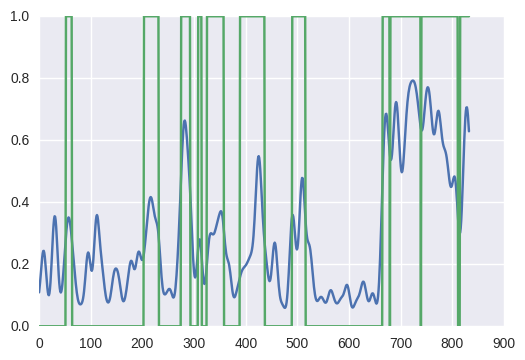

In [55]:
plt.plot([l for l in range(len(smooth_mask))], smooth_mask, [l for l in range(len(smooth_mask))], true_value)

In [56]:
np.corrcoef(smooth_mask, true_value)

array([[1.        , 0.77209959],
       [0.77209959, 1.        ]])

In [57]:
from sklearn.metrics import log_loss, f1_score, r2_score,confusion_matrix, classification_report,roc_curve, auc

fpr = {}
tpr = {}
roc_auc = {}
results = {"nn":real_mask,"smooth_nn":smooth_mask}
for k in results:
    fpr[k],tpr[k] ,_ = roc_curve(true_value, results[k])
    roc_auc[k] = auc(fpr[k], tpr[k])

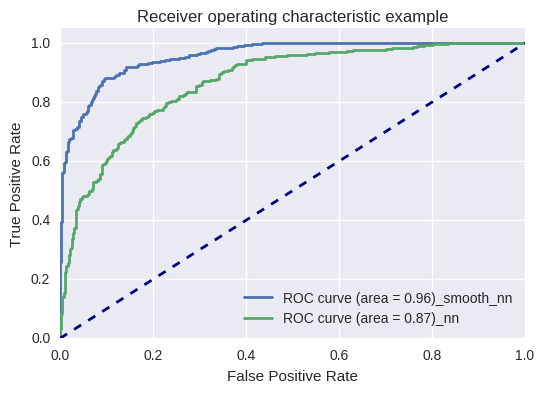

In [58]:
plt.figure()
for k in results:
    plt.plot(fpr[k], tpr[k],
             lw=2, label='ROC curve (area = %0.2f)_{}'.format(k) % roc_auc[k])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [1031]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_19 (Layer)             (None, None, 128)         0         
_________________________________________________________________
bidirectional_21 (Bidirectio (None, None, 64)          30912     
_________________________________________________________________
dropout_15 (Dropout)         (None, None, 64)          0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, None, 16)          1040      
_________________________________________________________________
time_distributed_21 (TimeDis (None, None, 1)           17        
Total params: 31,969
Trainable params: 31,969
Non-trainable params: 0
_________________________________________________________________


In [ ]:
## score - (smooth, nn)
## ./model_cpt/model_LG_None_gru_64_new_split_gdo.h5 - (0.92,0.86) - corr = (0.701)
## ./model_cpt/model_LG_None_gru_gru_64_new_split_gdo.h5 - (0.77,0.74)
## ./model_cpt/model_LG_None_gru_64_new_split_do.h5 - (0.69,0.66)
## ./model_cpt/model_LG_None_gru_64_new_split_dense_16.h5 - (0.69,0.69)
## ./model_cpt/model_LG_None_gru_64_new_split.h5 - (0.87,0.8)
## ./model_cpt/model_LG_None_gru_128.h5 - (0.88,0.88) -- good distribution of samples - corr = (0.675)
## ./model_cpt/model_LG_None_gru_gru_64_new_split_do.h5 - (0.81,0.79) - corr = (0.44) - smallest loss (0.1415)
## ./model_cpt/model_LG_None_gru_64_new_split_do_fast_sch.h5 - (0.91, 0.84) - corr = (0.69) 
## ./model_cpt/model_LG_None_gru_128_new_split_do_slow_sch.h5 - (0.79,0.72) - corr = (0.44)
## ./model_cpt/model_LG_None_gru_128_new_split_do_fast_sch.h5 - (0.92,0.89) - corr = (0.74)
## ./model_cpt/model_LG_None_gru_32_new_split_do_dense_16_fast_sch.h5 - (0.92,0.84) - corr = (0.716)
## ./model_cpt/model_LG_None_gru_32_new_split_do_fast_sch.h5 - (0.74,0.71)  - corr = (0.406)
## ./model_cpt/model_LG_None_gru_128_new_split_do_fast_sch.h5 - (0.96,0.87) - corr = (0.77) -- increase number of training samples